<a href="https://colab.research.google.com/github/Kennedy87670/Introduction-to-ML-DP/blob/main/04_transfer_learning_in_tensorflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 1: Feature Extraction

Transfer learning is leaveraging a working model's existing architecture and learned patterns for our own problem

There are two main benefits:
1. Can leverage an existing neaural network architecture proven towork on problems similar to our own
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own then we can adapt those patterns to our own

In [1]:
# are we using a gpu
!nvidia-smi

Mon Jul 18 20:29:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# get data (10% of food classes from food101)
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip the download file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-07-18 20:29:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 142.251.120.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   238MB/s    in 0.7s    

2022-07-18 20:29:11 (238 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# how many images in each folder
import os

# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 2 directories and 0 images in '10_food_classes_10_percent'. 
There are 10 directories and 0 images in '10_food_classes_10_percent/test'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'. 
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'. 
There are 0 directories and 250 images in '10_food_classes_10_p

## Create data loaders( preparing the data)
we will use the ImageDataGenerator class to load inour images in batches.

In [4]:
# setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS= 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen =ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent =train_datagen.flow_from_directory(train_dir,
                                                         target_size =IMAGE_SHAPE,
                                                         batch_size =BATCH_SIZE,
                                                         class_mode ="categorical"
)

print("Testing images:")
test_data= test_datagen.flow_from_directory(test_dir,
                                            target_size =IMAGE_SHAPE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = "categorical"
                                            )

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## setting up callbacks (things to run whilst our model trains)

callsbacks are extra functionality you can add to your models to be performed during or after training. some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the modelcheckpoint callback
* stopping a model from training (before it trains too long and overfits) with the earlystopping callback

In [5]:
# create tensorboard classback ( functionized because we need to create a new one for each model )
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log.files to:{log_dir}")
  return tensorboard_callback


# creating models using tensorflow hub

In the past we have used Tensorflow to create our own models layer by layer from scratch

Now we are going to do a similar process, except the majority of our model"s layers are going to come from tensorflow hub.

We can access pretrained models on:https://tfhub.dev/

BROWING THE tENSORFLOW hUB PAGE AND SORTING for images classification, we found the following feature vector model link: https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5

In [6]:
# lets compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# lets make a create model() function to create a model from a url
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub url and creates a keras Sequential model with it.

  Args:
    model_url (str): A tensorflow Hub feature extraction URL
    numb_classes(int): Number of output neurons in the output layer,
             should be equal to number of target classes, default 10.
  Returns: 
  An uncompiled Keras Sequential model with model_url as feature extractor
  layer and dense output layer with num_classes output neurons.
  """
  # download thepretarained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable =False,# freeze the already learned patterns
                                           name ="feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation = "softmax", name = "output_layer")

  ]
  )

  return model

# Creating and testing ResNet TensorFlow Hub feature extraction model 

In [9]:
# create a ResNet model
resnet_model = create_model(resnet_url, 
                            num_classes = train_data_10_percent.num_classes)

In [10]:
# compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics= ["accuracy"])

In [11]:
# fit our reset model to our data (10 percent of classes)
resent_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5 ,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps= len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                            experiment_name = "resnet50V2" )]
                                  )

Saving Tensorboard log.files to:tensorflow_hub/resnet50V2/20220718-202927
Epoch 1/5
24/24 [==============================] - 32s 756ms/step - loss: 1.9568 - accuracy: 0.3507 - val_loss: 1.2290 - val_accuracy: 0.5992
Epoch 2/5
24/24 [==============================] - 16s 684ms/step - loss: 0.8874 - accuracy: 0.7547 - val_loss: 0.8482 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6148 - accuracy: 0.8400 - val_loss: 0.7288 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 16s 674ms/step - loss: 0.4750 - accuracy: 0.8813 - val_loss: 0.7104 - val_accuracy: 0.7644
Epoch 5/5
24/24 [==============================] - 16s 676ms/step - loss: 0.3801 - accuracy: 0.9107 - val_loss: 0.6692 - val_accuracy: 0.7776


In [12]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


wow 
that is incredible. our transfer learning feature extractor model out performed all of the previous models we built by hand... (substantially) and in a quicker training time and with only 10% of the training examples

In [13]:
# lets create our function to plot our loss curves

#Tibit: you could put a function like this into a script called "helper.py" and import it when you need it
import matplotlib.pyplot as plt

# plot the validation and training curves seperately
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow history object

  returns:
     plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss= history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"])) # how many epochs did we run for?

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

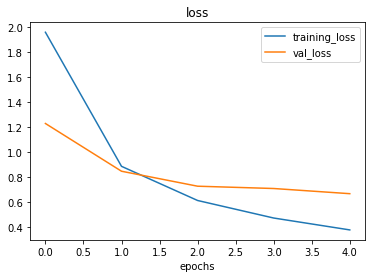

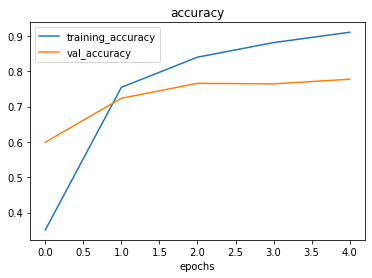

In [14]:
plot_loss_curves(resent_history)

# Creating and testing EfficientNetBO TensorFlow Hub feature extraction model 

In [15]:
# create a efficient model
efficientnet_model = create_model(efficientnet_url, 
                            num_classes = train_data_10_percent.num_classes)

In [16]:
# compile our EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics= ["accuracy"])

In [17]:
# fit our reset model to our data (10 percent of classes)
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs = 5 ,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps= len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                            experiment_name = "EfficientNetB0" )])

Saving Tensorboard log.files to:tensorflow_hub/EfficientNetB0/20220718-203126
Epoch 1/5
24/24 [==============================] - 25s 712ms/step - loss: 1.8251 - accuracy: 0.4707 - val_loss: 1.2863 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 15s 650ms/step - loss: 1.0444 - accuracy: 0.7987 - val_loss: 0.8549 - val_accuracy: 0.8148
Epoch 3/5
24/24 [==============================] - 16s 674ms/step - loss: 0.7429 - accuracy: 0.8520 - val_loss: 0.6904 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 15s 648ms/step - loss: 0.5986 - accuracy: 0.8747 - val_loss: 0.6062 - val_accuracy: 0.8504
Epoch 5/5
24/24 [==============================] - 15s 640ms/step - loss: 0.5071 - accuracy: 0.8907 - val_loss: 0.5551 - val_accuracy: 0.8560


In [18]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


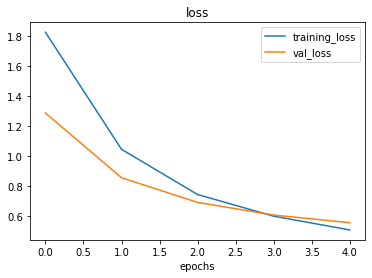

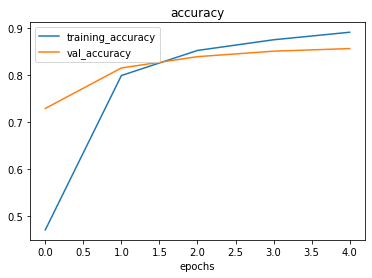

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
# how many layers does our efficientnet b0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different type of transfer learning

* "As is" transfer learning - using an existing model with no changes whatsoever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* "Feature extraction " transfer learning- use the prelearned patterns of an existing model (eg. EfficientNetB0trained on ImageNet) and adjust the output layer for your own problem (rg. 1000 classes -> 10 classes of food)
* "Fine Tuning transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

#comparing our models result using tensorbard


In [ ]:
# upload Tensor board  dev records
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs ResNet50V2" \
#   --description "comparing two differnt TF Hub featureextraction model archietecture using 10% of the training data"\
#   --one_shot

Our TensorBoard experiment are uploaded publically here: https://tensorboard.dev/experiment/3mH7NOgdQxK9lVouK8y2LQ/

In [22]:
# check out what tensorboard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/R2UNkfxwTJG6VQa70uLWmw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          comparing two differnt TF Hub featureextraction model archietecture using 10% of the training data
	Id                   R2UNkfxwTJG6VQa70uLWmw
	Created              2022-07-18 20:33:46 (14 seconds ago)
	Updated              2022-07-18 20:33:48 (12 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794963
https://tensorboard.dev/experiment/3mH7NOgdQxK9lVouK8y2LQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          comparing two differnt TF Hub featureextraction model archietecture using 10% of the training data
	Id                   3mH7NOgdQxK9lVouK8y2LQ
	Created              2022-07-17 22:20:09 (22 hours ago)
	Updated              2022-07-17 22:20:14 (22 hours ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes   

In [23]:
# delete anexperiment
# !tensorboard dev delete --experiment_id